In [1]:
library(tidyverse)
library(cowplot)
library(ggrepel)
library(pROC)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1       ✔ purrr   0.3.2  
✔ tibble  2.1.1       ✔ dplyr   0.8.0.1
✔ tidyr   0.8.3       ✔ stringr 1.4.0  
✔ readr   1.3.1       ✔ forcats 0.4.0  
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave

Type 'citation("pROC")' for a citation.

Attaching package: ‘pROC’

The following objects are masked from ‘package:stats’:

    cov, smooth, var



In [2]:
full_auroc_df <- read_csv('hetionet_auroc.csv')

full_auroc_df %>% head(2)

Parsed with column specification:
cols(
  metaedge = col_character(),
  network = col_character(),
  xswap_prior = col_double(),
  analytic_prior = col_double(),
  degree_product = col_double()
)


metaedge,network,xswap_prior,analytic_prior,degree_product
AdG,Original,0.9893888,0.9891555,0.9891437
AdG,Sample_50,0.9453517,0.9452759,0.9452496


## Original vs Sampled trend by feature

In [3]:
compare_features_trend <- full_auroc_df %>%
    gather('feature', 'auc', xswap_prior, analytic_prior, degree_product) %>%
    mutate(
        network = network %>% recode_factor(Original = 'Original', Sample_50 = '50%', 
                                            Sample_20 = '20%'),
        feature = feature %>% recode_factor(xswap_prior = "XSwap", analytic_prior = "Analytic",
                                            degree_product = "Degree")
    )

compare_features_trend %>% head(2)

metaedge,network,feature,auc
AdG,Original,XSwap,0.9893888
AdG,50%,XSwap,0.9453517


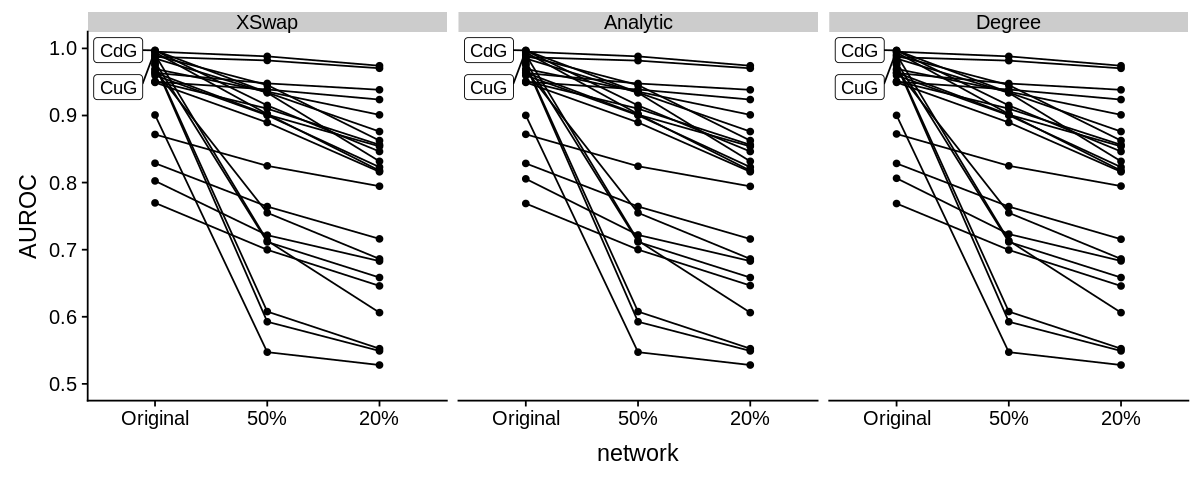

In [4]:
options(repr.plot.width=10, repr.plot.height=4)

(
    ggplot(compare_features_trend, aes(x = network, y = auc, group = metaedge, label = metaedge))
    + geom_point()
    + geom_line()
    + geom_label_repel(
        data = compare_features_trend %>%
            group_by(feature) %>%
            filter(network == 'Original') %>%
            top_n(2, wt = auc),
        nudge_x = -1
    )
    + facet_grid(cols = vars(feature))
    + ylim(0.5, 1)
    + ylab('AUROC')
)

## Compare features within each network

In [5]:
selected_labels_df <- bind_rows(
    full_auroc_df %>%
        filter(xswap_prior < 0.99 * degree_product) %>%
        select(-degree_product, -analytic_prior) %>%
        gather(feature, auc, xswap_prior) %>%
        mutate(
            network = network %>% recode_factor(Original = 'Original', 
                                                Sample_50 = '50%', 
                                                Sample_20 = '20%'),
            feature = feature %>% recode_factor(xswap_prior = "XSwap", 
                                                analytic_prior = "Analytic",
                                                degree_product = "Degree")
        ),
    full_auroc_df %>%
        gather('feature', 'auc', xswap_prior, analytic_prior, degree_product) %>%
        group_by(network) %>%
        filter(feature == 'xswap_prior') %>%
        top_n(2, wt = auc)  %>%
        ungroup() %>%
        mutate(
            network = network %>% recode_factor(Original = 'Original', 
                                                Sample_50 = '50%', 
                                                Sample_20 = '20%'),
            feature = feature %>% recode_factor(xswap_prior = "XSwap", 
                                                analytic_prior = "Analytic",
                                                degree_product = "Degree")
        )
)

Warning message in bind_rows_(x, .id):
“Unequal factor levels: coercing to character”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“Unequal factor levels: coercing to character”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”

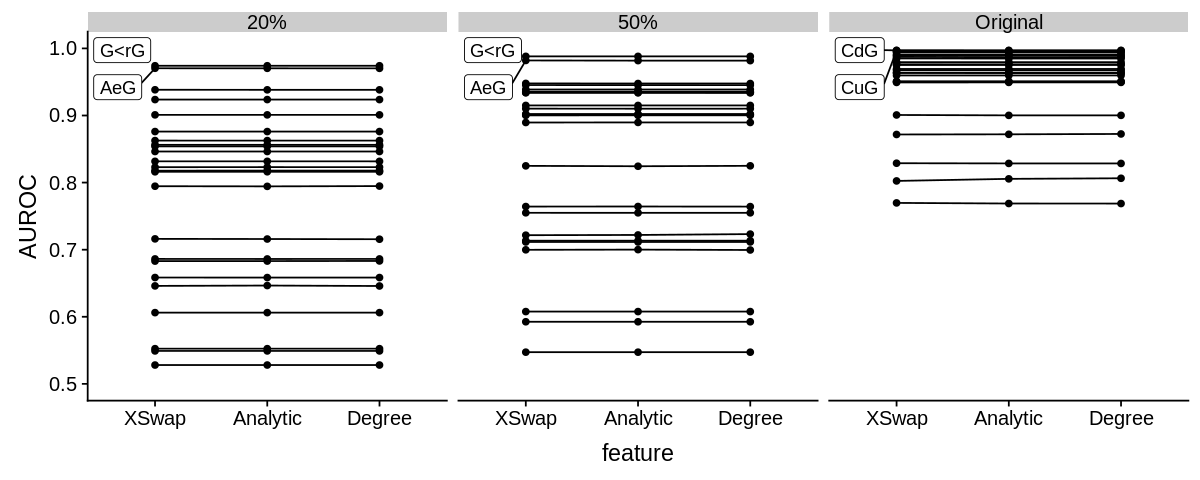

In [6]:
options(repr.plot.width=10, repr.plot.height=4)

(
   ggplot(compare_features_trend, aes(x = feature, y = auc, group = metaedge, label = metaedge))
    + geom_point()
    + geom_line()
    + geom_label_repel(data = selected_labels_df, nudge_x = -1)
    + facet_grid(cols = vars(network))
    + ylim(0.5, 1) 
    + ylab('AUROC')
)

Warning message:
“Ignoring unknown parameters: linestyle”

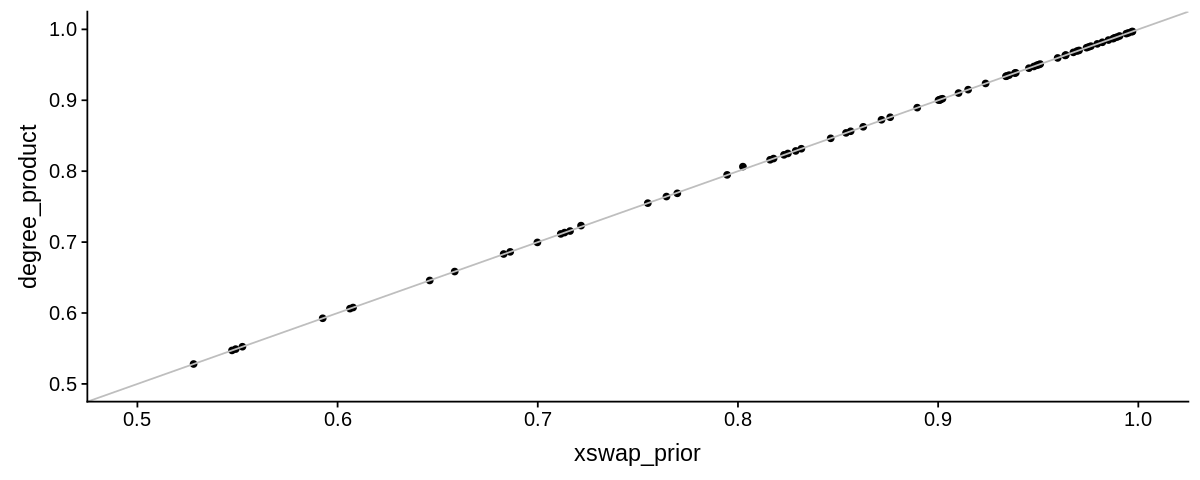

In [7]:
(
    ggplot(full_auroc_df, aes(x = xswap_prior, y = degree_product))
    + geom_point()
    + geom_abline(slope = 1, intercept = 0, color = 'grey', linestyle = 'dashed')
    + xlim(0.5, 1)
    + ylim(0.5, 1)
)

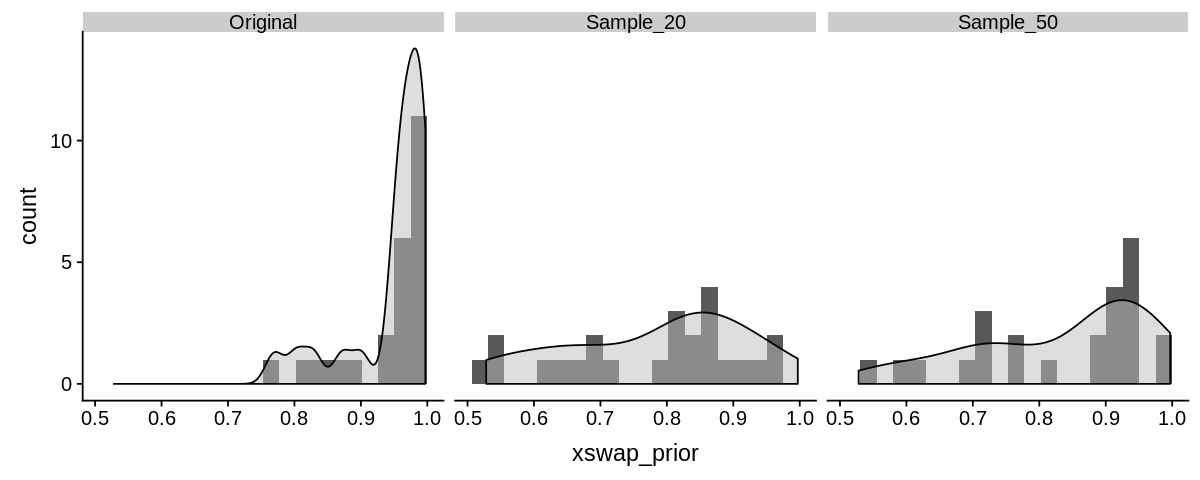

In [8]:
(
    ggplot(full_auroc_df, aes(x = xswap_prior))
    + geom_histogram(bins = 20)
    + geom_density(fill = 'grey', alpha = 0.5)
    + facet_wrap('network')
)